In [1]:
#packages
import pandas as pd
import numpy as np
import warnings
import sqlite3

from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRFRegressor

In [2]:
# hide warnings
warnings.filterwarnings('ignore')

In [3]:
def prepare_data():
    df = read_data()
    df = format_columns(df)
    #df = select_columns(df)
    
    df["zipcode"] = pd.to_numeric(df["zipcode"], errors='coerce')
    df["station_area"] = pd.to_numeric(df["station_area"], errors='coerce')
    df["ems_units"] = pd.to_numeric(df["ems_units"], errors='coerce')
    df["supervisor_district"] = pd.to_numeric(df["supervisor_district"], errors='coerce')
    
    #Ignore NaN rows
    df = df[df['minutes'].notna()]
    df = df[df['point_x'].notna()]
    df = df[df['point_y'].notna()]
    df = df[df['zipcode'].notna()]
    df = df[df['station_area'].notna()]
    df = df[df['ems_units'].notna()]
    df = df[df['supervisor_district'].notna()]
    
    return df

In [4]:
def read_data():
    con = sqlite3.connect("fire_data_v3.db")
    cur = con.cursor()

    df = pd.read_sql('SELECT ' \
                     'fi.zipcode, fi.supervisor_district, fi.alarm_dttm, fi.arrival_dttm, fi.box, fi.ems_units, fi.station_area, cfs.case_location ' \
                     'FROM fire_incidents AS fi INNER JOIN calls_for_service AS cfs ON fi.incident_number = cfs.incident_number INNER JOIN nearest_distances AS nd ON fi.incident_number = nd.incident_number',con = con)
    
    return df

In [5]:
def format_columns(df):
    df['alarm_format'] = pd.to_datetime(df['alarm_dttm'])
    df['arrival_format'] = pd.to_datetime(df['arrival_dttm'])
    df['arrival_time'] = (df['arrival_format'] - df['alarm_format'])
    df['minutes'] = (df.arrival_time.dt.seconds) / 60
    df['seconds'] = (df.arrival_time.dt.seconds)
    df['day_of_week'] = df['alarm_format'].dt.dayofweek
    df['dayflag'] = (df.alarm_format.dt.hour > 5) & (df.alarm_format.dt.hour < 18)
    
    point = df['case_location'].str.split(' ', n = 2, expand = True)
    point_x = point[1].str.split('(', n = 1, expand = True)
    point_y = point[2].str.split(')', n = 1, expand = True)
    
    df['point_x'] = point_x[1]
    df['point_y'] = point_y[0]
    
    return df

In [6]:
def select_columns(df):
    cols = ['minutes','seconds','alarm_format','arrival_format','day_of_week','dayflag','zipcode',\
        'station_area', 'ems_units', 'supervisor_district'\
        'arrival_time', 'point_x', 'point_y']
    
    return df[cols]

In [7]:
df = prepare_data()
df.head()

,zipcode,supervisor_district,alarm_dttm,arrival_dttm,box,ems_units,station_area,case_location,alarm_format,arrival_format,arrival_time,minutes,seconds,day_of_week,dayflag,point_x,point_y
0,94110.0,9.0,2008-04-01 18:06:37,2008-04-01 18:15:19,None,0,11.0,POINT (-122.418144723562 37.742224086608),2008-04-01 18:06:37,2008-04-01 18:15:19,0 days 00:08:42,8.700000,522.0,1,False,-122.418144723562,37.742224086608
1,94107.0,10.0,2008-04-01 18:00:52,2008-04-01 18:06:30,None,0,37.0,POINT (-122.395114989 37.756639987211),2008-04-01 18:00:52,2008-04-01 18:06:30,0 days 00:05:38,5.633333,338.0,1,False,-122.395114989,37.756639987211
12,94102.0,5.0,2008-04-01 19:03:52,2008-04-01 19:08:39,None,0,36.0,POINT (-122.427077545588 37.776304759752),2008-04-01 19:03:52,2008-04-01 19:08:39,0 days 00:04:47,4.783333,287.0,1,False,-122.427077545588,37.776304759752
17,94109.0,3.0,2008-04-01 20:09:55,2008-04-01 20:12:29,None,0,1.0,POINT (-122.405221175679 37.788693991132),2008-04-01 20:09:55,2008-04-01 20:12:29,0 days 00:02:34,2.566667,154.0,1,False,-122.405221175679,37.788693991132
18,94109.0,3.0,2008-04-01 20:09:55,2008-04-01 20:12:29,None,0,1.0,POINT (-122.405221175679 37.788693991132),2008-04-01 20:09:55,2008-04-01 20:12:29,0 days 00:02:34,2.566667,154.0,1,False,-122.405221175679,37.788693991132


In [8]:
class ModelData:
    x = None
    y = None
    x_train = None
    x_test = None
    y_train = None
    y_test = None

    model = None
    target_to_predict = None
    predictors = None
    XGB = None

In [21]:
def configure_sets(md):
    md.target_to_predict = 'minutes'
    md.predictors = ['zipcode', 'day_of_week','station_area', 'ems_units', 'supervisor_district', 'point_x', 'point_y']
    
    md.x = df[md.predictors].values
    md.y = df[md.target_to_predict].values

    #Split the data into training and testing set
    md.x_train, md.x_test, md.y_train, md.y_test = train_test_split(md.x, md.y, test_size=0.8, random_state=42)

In [22]:
def create_model(md):
    #RegModel = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500, objective='reg:linear', booster='gbtree')
    md.model = XGBRFRegressor(n_estimators=4000, subsample=0.9, colsample_bynode=0.2)

    #Printing all the parameters of XGBoost
    print(md.model)
    
    #Creating the model on Training Data
    md.XGB = md.model.fit(md.x_train, md.y_train)
    
    prediction = md.XGB.predict(md.x_test)

    #Measuring Goodness of fit in Training data
    print('R2 Value:', metrics.r2_score(md.y_train, md.XGB.predict(md.x_train)))

    #Measuring accuracy on Testing Data
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction) / md.y_test)) * 100))

    #Plotting the feature importance for Top 10 most important columns 
    %matplotlib inline
    feature_importances = pd.Series(md.XGB.feature_importances_, index = md.predictors)
    feature_importances.nlargest(10).plot(kind = 'barh')

In [23]:
def cross_validate_model(md):
    # define the model evaluation procedure
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    # evaluate the model and collect the scores
    n_scores = cross_val_score(md.model, md.x, md.y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    # report performance
    print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [24]:
def predict_single_value(md):
    row = [-122.429504, 37.783009]
    row = asarray([row])
    
    prediction = md.model.predict(row)
    
    print('Prediction: %f' % prediction[0])

In [25]:
def predict_using_training_set(md):
    prediction = md.XGB.predict(md.x_test)
    
    training_set_predictions = pd.DataFrame(data = md.x_test, columns = md.predictors)
    training_set_predictions[md.target_to_predict] = md.y_test
    training_set_predictions[('Predicted' + md.target_to_predict)] = prediction
    training_set_predictions.head()
    
    print(training_set_predictions)

XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=0.2, colsample_bytree=None,
               enable_categorical=False, gamma=None, gpu_id=None,
               importance_type=None, interaction_constraints=None,
               max_delta_step=None, max_depth=None, min_child_weight=None,
               missing=nan, monotone_constraints=None, n_estimators=4000,
               n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, scale_pos_weight=None, subsample=0.9,
               tree_method=None, validate_parameters=None, verbosity=None)
R2 Value: 0.034378935875076344
Accuracy -inf


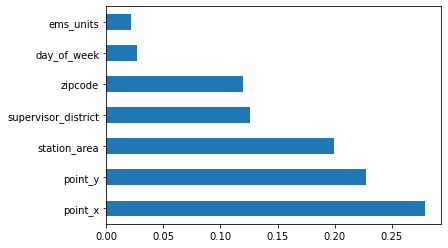

In [26]:
model_data = ModelData()

configure_sets(model_data)
create_model(model_data)
#cross_validate_model(model_data)

In [27]:
#predict_single_value(model_data)

In [28]:
predict_using_training_set(model_data)

        zipcode day_of_week station_area ems_units supervisor_district  \
0       94108.0           2         13.0         0                 3.0   
1       94133.0           4         28.0         0                 3.0   
2       94118.0           1         31.0         2                 1.0   
3       94112.0           3         15.0         0                 7.0   
4       94129.0           3         51.0         0                 2.0   
...         ...         ...          ...       ...                 ...   
651923  94118.0           0         31.0         0                 2.0   
651924  94109.0           2          3.0         0                 2.0   
651925  94108.0           3         13.0         1                 3.0   
651926  94114.0           5         33.0         0                11.0   
651927  94124.0           0         25.0         0                10.0   

                    point_x             point_y    minutes  Predictedminutes  
0       -122.40745780854324  37.